In [1]:
import tensorflow as tf
import keras
import os

In [38]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [69]:
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

In [72]:
TRAIN_PATH = './images-fresh-Shaima-CNN/train'
TEST_PATH = './images-fresh-Shaima-CNN/test'
CLASS_NAMES = ['hello', 'help', 'iloveyou', 'no', 'yes']
BATCH_SIZE = 4
IMAGE_SIZE = (180, 180)
NUM_CLASSES = 5
EPOCHS = 10
KF = KFold(n_splits = 5)
SKF = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
print(os.listdir(TRAIN_PATH))
print(os.listdir(TEST_PATH))

['no', 'hello', 'yes', 'iloveyou', 'help']
['no', 'hello', 'yes', 'iloveyou', 'help']


Preprocessing Images

In [58]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=IMAGE_SIZE,
    validation_split=0.1,
    seed=1337,
    batch_size=BATCH_SIZE,
    subset="training"
)

# Create test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    label_mode='categorical',
    color_mode='grayscale',
    validation_split = 0.1,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation"
)

print("Datasets created successfully.")

Found 39 files belonging to 5 classes.
Using 36 files for training.
Found 10 files belonging to 5 classes.
Found 39 files belonging to 5 classes.
Using 3 files for validation.
Datasets created successfully.


In [59]:
for images, labels in train_dataset.take(1):
    print(labels)

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]], shape=(4, 5), dtype=float32)


In [74]:
train_dataset.class_names

['hello', 'help', 'iloveyou', 'no', 'yes']

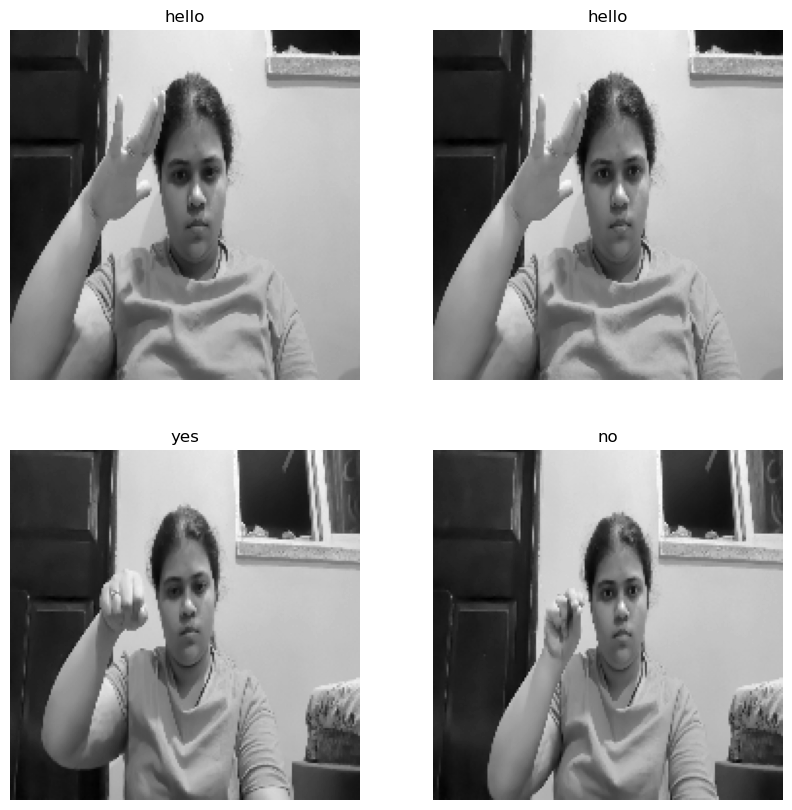

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Assuming you want to visualize from the train_dataset
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().squeeze().astype("uint8"), cmap='gray')  # Squeeze to remove the single-channel dimension
        plt.title(CLASS_NAMES[tf.argmax(labels[i]).numpy()])  # Assuming labels are one-hot encoded
        plt.axis("off")
plt.show()


Model Creation


In [61]:
# Define the CNN model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 1)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])
def cnn_model():

    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(180, 180, 1)),
        layers.Conv2D(16, 1, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 1, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 1, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [62]:
model = cnn_model()

In [63]:
# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      32        
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        544       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

Defining the callbacks

In [64]:
#set early stopping criteria
pat = 2 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model-test-with-callback.h5', verbose=1, save_best_only=True)

In [67]:
def fit_and_evaluate(train, validation, EPOCHS=10, BATCH_SIZE=4):
    model = None
    model = cnn_model()
    results = model.fit(train, validation, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(validation))
    return results
# # Fit the model 
# epochs = 10
# history = model.fit(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     epochs=epochs,
#     callbacks=[early_stopping, model_checkpoint],
#     verbose=1, 
#     validation_split=0.1
# )
# print("Val Score: ", model.evaluate(val_x, val_y))

K-fold cross validation

In [68]:
n_folds = 3
model_history = []
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    # t_x, val_x, t_y, val_y = train_test_split(train_dataset, train_dataset, test_size=0.1, 
    #                                            random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(train_dataset, validation_dataset, EPOCHS, BATCH_SIZE))
    print("======="*12, end="\n\n\n")

Training on Fold:  1


ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>, <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>]

In [23]:
# # Fit the model 
# epochs = 10
# history = model.fit(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     epochs=epochs,
#     callbacks=[early_stopping, model_checkpoint],
#     verbose=1, 
#     validation_split=0.1
# )
# print("Val Score: ", model.evaluate(val_x, val_y))

Epoch 1/10
10/10 [==============================] - 0s 13ms/step - loss: 1.7753 - accuracy: 0.2051
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 1.5054 - accuracy: 0.4615
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 1.3288 - accuracy: 0.7179
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 1.0941 - accuracy: 0.5385
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.6996 - accuracy: 0.7436
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.4814 - accuracy: 0.8205
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.1624 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0679 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0234 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0118 - accuracy: 1.0000


In [24]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")

print("Model trained and evaluated successfully.")

3/3 [==============================] - 0s 4ms/step - loss: 0.0096 - accuracy: 1.0000
Test accuracy: 1.0
Test Accuracy: 1.0
Model trained and evaluated successfully.


In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')
plt.plot(model_history[2].history['acc'], label='Training Fold 3')
plt.legend()
plt.show()

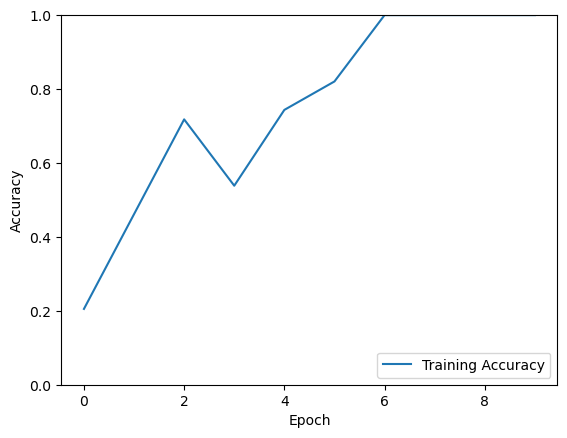

In [25]:
# import matplotlib.pyplot as plt

# # Plot training accuracy
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
# plt.show()

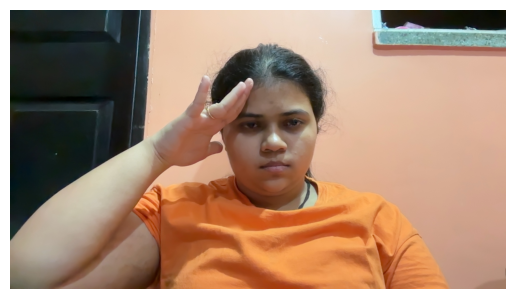

In [27]:
import numpy as np
import matplotlib.pyplot as plt

test_image_path = './images-fresh-Shaima-CNN/test/hello/hello.0715ec40-03c2-11ef-a8a4-7e09ada021c9.jpg'
# Load the test image
test_image = plt.imread(test_image_path)

# Display the test image
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [28]:
# Resize the test image if necessary (assuming 'image_size' is the desired size)
image_size=[180, 180]
if test_image.shape[:2] != image_size:
    test_image = tf.image.resize(test_image, image_size)
# Convert the resized image to grayscale
test_image_gray = tf.image.rgb_to_grayscale(test_image)
test_image_gray = tf.expand_dims(test_image_gray, axis=0)  # Add batch dimension


In [29]:
# Predict the class of the test image using the trained model
predictions = model.predict(test_image_gray)

# Convert predictions to numpy array
predictions = np.array(predictions)

1/1 [==============================] - 0s 64ms/step


In [30]:
predictions

array([[9.9689144e-01, 4.0959694e-05, 2.9205233e-03, 4.6363374e-07,
        1.4664943e-04]], dtype=float32)

In [32]:
# Find the index of the maximum value in the array
predicted_class_index = np.argmax(predictions)

# Output the predicted class index
print("Predicted class index:", predicted_class_index)

predicted_class_label = CLASS_NAMES[predicted_class_index]
print("Predicted class is:", predicted_class_label)

Predicted class index: 0
Predicted class is: hello


In [33]:
model.save('cnn_Shaima_test-1.h5')

/Users/shaimahaque/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
model.save('cnn_Shaima-test-1.keras')